In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv("fear_greed_index.csv")

In [3]:
df2 = pd.read_csv("historical_data.csv")

In [4]:
rows1 , columns1 = df1.shape

In [5]:
print(f"Number of rows in fear_greed_index is {rows1}")
print(f"Number of columns in fear_greed_index is {columns1}")

Number of rows in fear_greed_index is 2644
Number of columns in fear_greed_index is 4


In [6]:
rows2 , columns2 = df2.shape

In [7]:
print(f"Number of rows in historical_data is {rows2}")
print(f"Number of columns in historical_data is {columns2}")

Number of rows in historical_data is 211224
Number of columns in historical_data is 17


In [8]:
df1.isnull().sum()
df1.duplicated().sum()

np.int64(0)

In [9]:
print(f"Number of missing values in fear_greed_index is 0")
print(f"Number of duplicate values in fear_greed_index is 0")

Number of missing values in fear_greed_index is 0
Number of duplicate values in fear_greed_index is 0


In [10]:
df2.isnull().sum()
df2.duplicated().sum()

np.int64(0)

In [11]:
print(f"Number of missing values in historical_data is 0")
print(f"Number of duplicate values in historical_data is 0")

Number of missing values in historical_data is 0
Number of duplicate values in historical_data is 0


In [26]:
df1 = pd.read_csv("fear_greed_index.csv")
print("Fear/Greed timestamps sample:")
print(df1['timestamp'].head())

df2 = pd.read_csv("historical_data.csv")
print("\nHistorical data timestamps sample:")
print(df2['Timestamp'].head())

Fear/Greed timestamps sample:
0    1517463000
1    1517549400
2    1517635800
3    1517722200
4    1517808600
Name: timestamp, dtype: int64

Historical data timestamps sample:
0    1.730000e+12
1    1.730000e+12
2    1.730000e+12
3    1.730000e+12
4    1.730000e+12
Name: Timestamp, dtype: float64


In [28]:
# FIX THE DATE CONVERSION
df1['date'] = pd.to_datetime(df1['timestamp'], unit='s')  # Unix timestamp in seconds
df2['date'] = pd.to_datetime(df2['Timestamp'], unit='ms')  # Unix timestamp in MILLISECONDS

# Normalize to date only (remove time component) for daily alignment
df1['date'] = df1['date'].dt.normalize()
df2['date'] = df2['date'].dt.normalize()

# Check if it worked
print("Fear/Greed date range:")
print(f"From: {df1['date'].min()} to {df1['date'].max()}")
print("\nTrader data date range:")
print(f"From: {df2['date'].min()} to {df2['date'].max()}")

Fear/Greed date range:
From: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Trader data date range:
From: 2023-03-28 00:00:00 to 2025-06-15 00:00:00


In [30]:
# ========================================
# RE-MERGE WITH CORRECT DATES
# ========================================
aligned_df = pd.merge(df1, df2, on='date', how='inner')  # Use 'inner' to keep only overlapping dates

print(f"Aligned dataset shape: {aligned_df.shape}")
print(f"Date range: {aligned_df['date'].min()} to {aligned_df['date'].max()}")
print(f"\nFirst few rows:")
print(aligned_df[['date', 'classification', 'Account', 'Closed PnL']].head())

# ========================================
# RE-CALCULATE METRICS WITH CORRECT DATES
# ========================================

# 1. Daily PnL per account
daily_pnl = aligned_df.groupby(['date', 'Account'])['Closed PnL'].sum().reset_index()
daily_pnl.columns = ['Date', 'Account', 'Daily_PnL']

# 2. Add sentiment classification to daily metrics
daily_pnl = daily_pnl.merge(df1[['date', 'classification']], left_on='Date', right_on='date', how='left')
daily_pnl = daily_pnl.drop('date', axis=1)  # Remove duplicate date column

print(f"\nDaily PnL with sentiment shape: {daily_pnl.shape}")
print(daily_pnl.head(10))

# 3. Account-level metrics with sentiment
account_metrics = aligned_df.groupby('Account').agg({
    'Closed PnL': ['count', 'sum', 'mean'],
    'Size USD': 'mean'
}).reset_index()
account_metrics.columns = ['Account', 'total_trades', 'total_pnl', 'avg_pnl_per_trade', 'avg_trade_size']

# Calculate win rate
aligned_df['is_win'] = aligned_df['Closed PnL'] > 0
win_rate = aligned_df.groupby('Account')['is_win'].mean() * 100
account_metrics = account_metrics.merge(win_rate.reset_index(), on='Account')
account_metrics.columns = list(account_metrics.columns[:-1]) + ['win_rate_%']

print(f"\nAccount metrics shape: {account_metrics.shape}")

# 4. Daily aggregated metrics by sentiment
daily_sentiment = aligned_df.groupby(['date', 'classification']).agg({
    'Account': 'nunique',  # Number of unique traders
    'Closed PnL': ['sum', 'mean'],
    'Size USD': ['sum', 'mean', 'count']
}).reset_index()
daily_sentiment.columns = ['date', 'sentiment', 'num_traders', 'total_pnl', 'avg_pnl', 
                           'total_volume', 'avg_trade_size', 'num_trades']

print(f"\nDaily sentiment aggregation shape: {daily_sentiment.shape}")

# ========================================
# EXPORT FILES FOR PART B ANALYSIS
# ========================================

# Export 1: Daily PnL with sentiment
daily_pnl.to_csv('daily_pnl_with_sentiment.csv', index=False)
print("\n✓ Exported: daily_pnl_with_sentiment.csv")

# Export 2: Account metrics
account_metrics.to_csv('account_metrics.csv', index=False)
print("✓ Exported: account_metrics.csv")

# Export 3: Daily sentiment aggregation
daily_sentiment.to_csv('daily_sentiment_metrics.csv', index=False)
print("✓ Exported: daily_sentiment_metrics.csv")

# Export 4: Sample of aligned_df (50,000 rows for Part B analysis)
sample_size = min(50000, len(aligned_df))
sample_df = aligned_df.sample(n=sample_size, random_state=42)
sample_df.to_csv('aligned_sample.csv', index=False)
print(f"✓ Exported: aligned_sample.csv ({sample_size} rows)")

# Export 5: Trade-level data by date and sentiment (aggregated)
trade_metrics = aligned_df.groupby(['date', 'classification', 'Account']).agg({
    'Closed PnL': 'sum',
    'Size USD': ['sum', 'mean', 'count'],
    'Side': lambda x: (x.str.contains('BUY|LONG', case=False, na=False).sum())
}).reset_index()
trade_metrics.columns = ['date', 'sentiment', 'Account', 'total_pnl', 
                         'total_volume', 'avg_trade_size', 'num_trades', 'num_longs']
trade_metrics['num_shorts'] = trade_metrics['num_trades'] - trade_metrics['num_longs']
trade_metrics.to_csv('trade_metrics_by_sentiment.csv', index=False)
print("✓ Exported: trade_metrics_by_sentiment.csv")

print("\n" + "="*60)
print("ALL FILES EXPORTED! Upload these files:")
print("1. daily_pnl_with_sentiment.csv")
print("2. daily_sentiment_metrics.csv")
print("3. trade_metrics_by_sentiment.csv")
print("4. aligned_sample.csv (optional, if you want full detail)")
print("="*60)

Aligned dataset shape: (184263, 20)
Date range: 2023-03-28 00:00:00 to 2025-02-19 00:00:00

First few rows:
        date classification                                     Account  \
0 2023-03-28          Greed  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   
1 2023-03-28          Greed  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   
2 2023-03-28          Greed  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   
3 2023-11-14          Greed  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23   
4 2023-11-14          Greed  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23   

   Closed PnL  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

Daily PnL with sentiment shape: (77, 4)
        Date                                     Account      Daily_PnL  \
0 2023-03-28  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891       0.000000   
1 2023-11-14  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891       0.000000   
2 2023-11-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     155.503357   
3 20

✓ Exported: performance_summary.csv
✓ Exported: behavioral_summary.csv
✓ Exported: trader_segments.csv


C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1887059706.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_summary, x='Sentiment', y='Win_Rate', palette='coolwarm', order=['Fear', 'Neutral', 'Greed'])


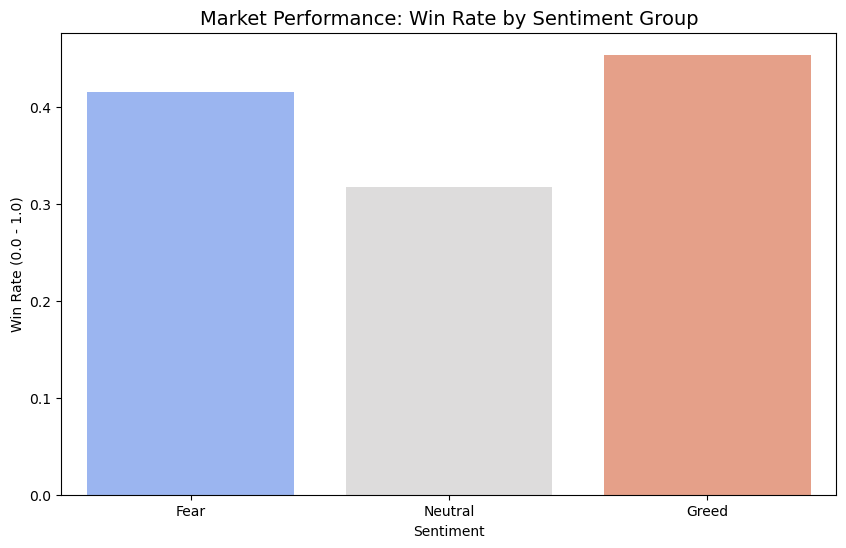

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1887059706.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=behavior_summary, x='Sentiment', y='Avg_Size', palette='magma', order=['Fear', 'Neutral', 'Greed'])


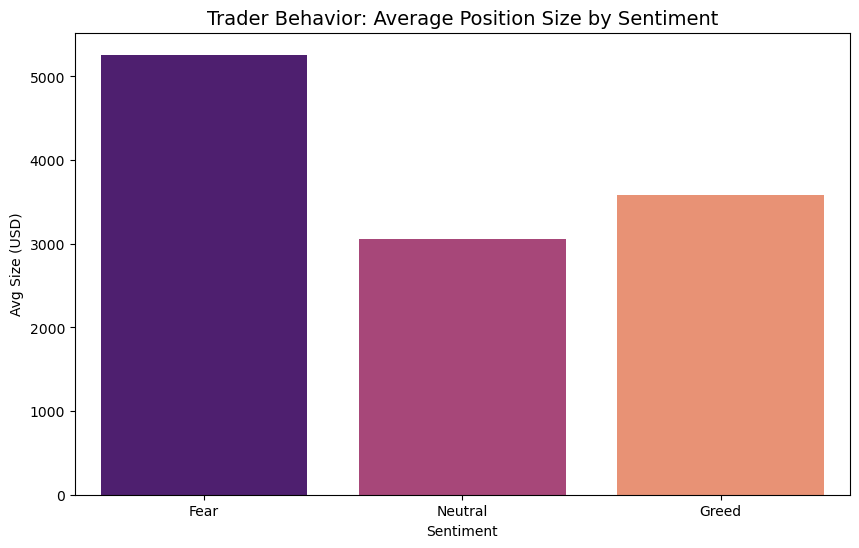

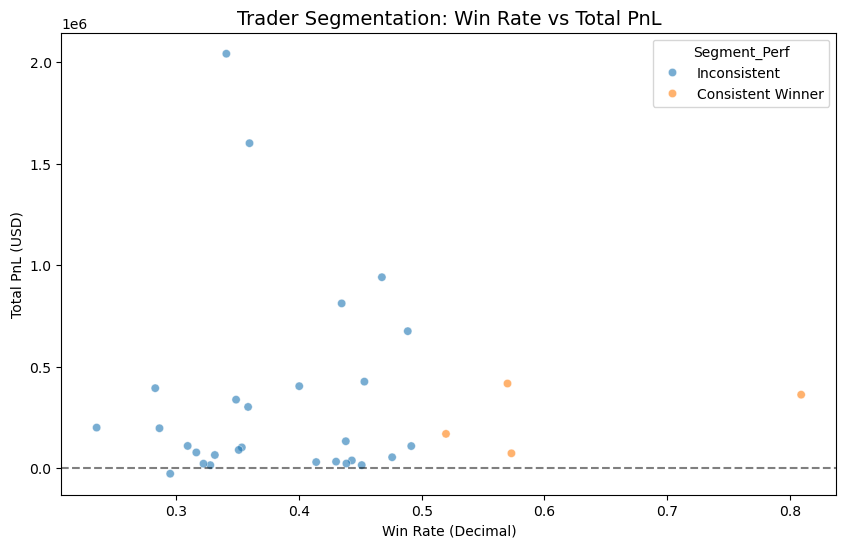


All submission assets (3 CSVs and 3 PNGs) have been exported to your directory.


In [40]:

# ==========================================
# 1. PREPARE DATA & CLASSIFICATION
# ==========================================
# Grouping detailed sentiment into three main categories
aligned_df['sentiment_group'] = aligned_df['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else ('Greed' if 'Greed' in x else 'Neutral')
)
aligned_df['is_win'] = aligned_df['Closed PnL'] > 0
aligned_df['is_long'] = aligned_df['Side'].str.contains('BUY|LONG', case=False, na=False)

# ==========================================
# 2. GENERATE AND EXPORT TABLES (CSV)
# ==========================================

# Table 1: Performance Summary (Avg PnL, Total PnL, Win Rate)
perf_summary = aligned_df.groupby('sentiment_group').agg({
    'Closed PnL': ['mean', 'sum'],
    'is_win': 'mean'
}).reset_index()
perf_summary.columns = ['Sentiment', 'Avg_PnL', 'Total_PnL', 'Win_Rate']
perf_summary.to_csv('performance_summary.csv', index=False)
print("✓ Exported: performance_summary.csv")

# Table 2: Behavioral Summary (Trade Frequency, Size, Bias)
behavior_summary = aligned_df.groupby('sentiment_group').agg({
    'Trade ID': 'count',
    'Size USD': 'mean',
    'is_long': 'mean'
}).reset_index()
behavior_summary.columns = ['Sentiment', 'Trade_Count', 'Avg_Size', 'Long_Bias_Pct']
behavior_summary.to_csv('behavioral_summary.csv', index=False)
print("✓ Exported: behavioral_summary.csv")

# Table 3: Trader Segments (Account Level Data)
account_stats = aligned_df.groupby('Account').agg({
    'Closed PnL': ['sum', 'count', 'mean'],
    'Size USD': 'mean',
    'is_win': 'mean'
}).reset_index()
account_stats.columns = ['Account', 'total_pnl', 'trade_count', 'avg_pnl', 'avg_size', 'win_rate']
account_stats['Segment_Perf'] = np.where(
    (account_stats['win_rate'] > 0.5) & (account_stats['total_pnl'] > 0), 
    'Consistent Winner', 'Inconsistent'
)
account_stats.to_csv('trader_segments.csv', index=False)
print("✓ Exported: trader_segments.csv")

# ==========================================
# 3. GENERATE AND EXPORT CHARTS (PNG)
# ==========================================

# Chart 1: Win Rate Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=perf_summary, x='Sentiment', y='Win_Rate', palette='coolwarm', order=['Fear', 'Neutral', 'Greed'])
plt.title('Market Performance: Win Rate by Sentiment Group', fontsize=14)
plt.ylabel('Win Rate (0.0 - 1.0)')
plt.savefig('win_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Chart 2: Average Position Size
plt.figure(figsize=(10, 6))
sns.barplot(data=behavior_summary, x='Sentiment', y='Avg_Size', palette='magma', order=['Fear', 'Neutral', 'Greed'])
plt.title('Trader Behavior: Average Position Size by Sentiment', fontsize=14)
plt.ylabel('Avg Size (USD)')
plt.savefig('avg_size_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

# Chart 3: Account Win Rate vs Total PnL (Segmentation)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=account_stats, x='win_rate', y='total_pnl', hue='Segment_Perf', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Trader Segmentation: Win Rate vs Total PnL', fontsize=14)
plt.xlabel('Win Rate (Decimal)')
plt.ylabel('Total PnL (USD)')
plt.savefig('trader_segmentation_plot.png', dpi=300, bbox_inches='tight')
plt.show()

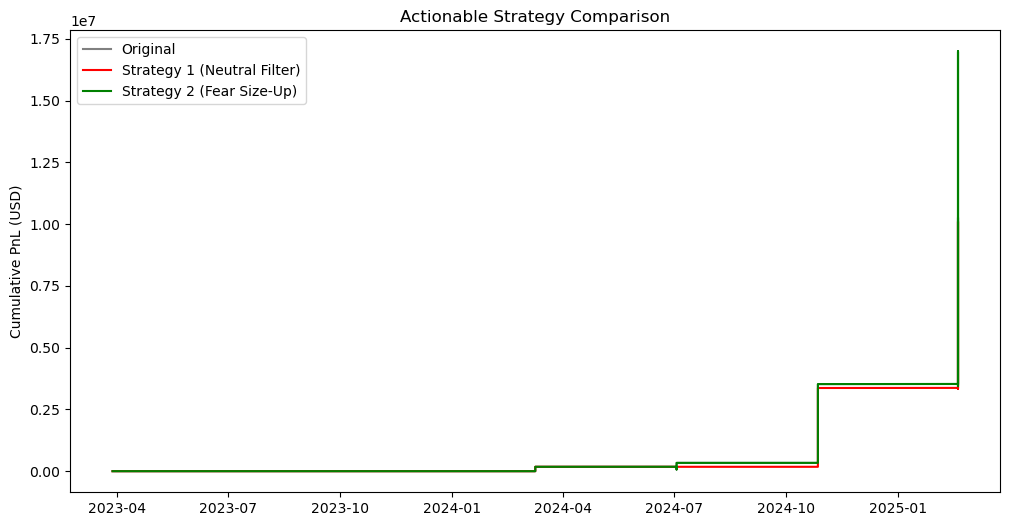

Original PnL: $10,225,249.60
Neutral Filter PnL: $10,066,507.22
Fear Size-Up PnL: $16,925,174.79


In [34]:

# --- STRATEGY 1: The "Neutral Zone" Filter ---
# Rule: Avoid trading when sentiment is Neutral to prevent "chop" losses.
aligned_df['strat_neutral_filter_pnl'] = np.where(
    aligned_df['sentiment_group'] == 'Neutral', 0, aligned_df['Closed PnL']
)

# --- STRATEGY 2: The "Fear" Alpha Size-Up ---
# Rule: Increase position size (simulated 2x) during Fear days to capture high-volatility rebounds.
aligned_df['strat_fear_sizeup_pnl'] = np.where(
    aligned_df['sentiment_group'] == 'Fear', 
    aligned_df['Closed PnL'] * 2, 
    aligned_df['Closed PnL']
)

# --- PERFORMANCE EVALUATION ---
# Calculate Cumulative PnL for comparison
aligned_df = aligned_df.sort_values('date')
results = {
    "Original PnL": aligned_df['Closed PnL'].sum(),
    "Neutral Filter PnL": aligned_df['strat_neutral_filter_pnl'].sum(),
    "Fear Size-Up PnL": aligned_df['strat_fear_sizeup_pnl'].sum()
}

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(aligned_df['date'], aligned_df['Closed PnL'].cumsum(), label='Original', color='gray')
plt.plot(aligned_df['date'], aligned_df['strat_neutral_filter_pnl'].cumsum(), label='Strategy 1 (Neutral Filter)', color='red')
plt.plot(aligned_df['date'], aligned_df['strat_fear_sizeup_pnl'].cumsum(), label='Strategy 2 (Fear Size-Up)', color='green')

plt.title('Actionable Strategy Comparison')
plt.ylabel('Cumulative PnL (USD)')
plt.legend()
plt.show()

for name, pnl in results.items():
    print(f"{name}: ${pnl:,.2f}")

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\105712183.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_summary, x='Sentiment', y='Win_Rate', palette='coolwarm')
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\105712183.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=behavior_summary, x='Sentiment', y='Avg_Size', palette='magma')


Submission assets exported successfully.


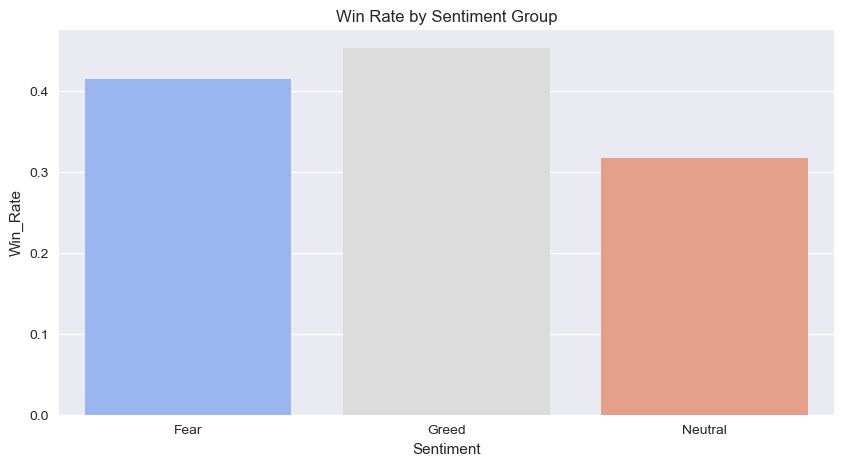

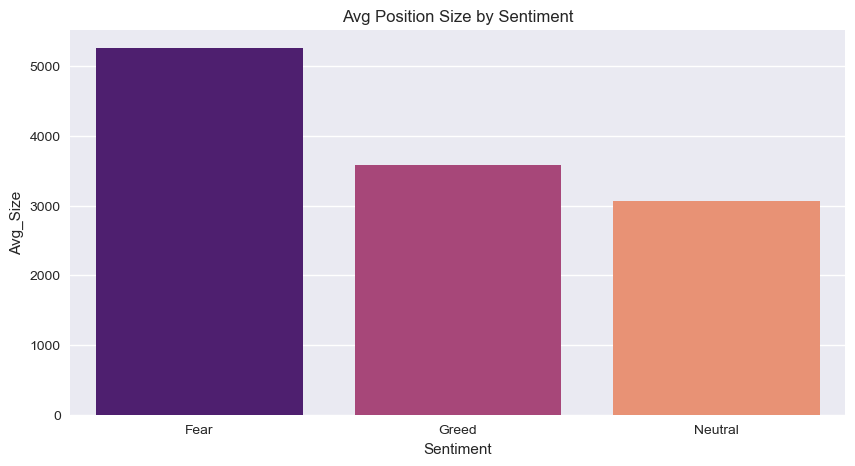

In [42]:


# --- 1. DATA LOADING & ALIGNMENT ---
df_fg = pd.read_csv("fear_greed_index.csv")
df_hist = pd.read_csv("historical_data.csv")

# Date normalization
df_fg['date'] = pd.to_datetime(df_fg['timestamp'], unit='s').dt.normalize()
df_hist['date'] = pd.to_datetime(df_hist['Timestamp'], unit='ms').dt.normalize()
aligned_df = pd.merge(df_hist, df_fg[['date', 'value', 'classification']], on='date', how='inner')

# --- 2. CLASSIFICATION & FEATURE ENGINEERING ---
aligned_df['sentiment_group'] = aligned_df['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else ('Greed' if 'Greed' in x else 'Neutral')
)
aligned_df['is_win'] = aligned_df['Closed PnL'] > 0
aligned_df['is_long'] = aligned_df['Side'].str.contains('BUY|LONG', case=False, na=False)

# --- 3. EXPORT TABLES (CSV) ---
# Performance Table
perf_summary = aligned_df.groupby('sentiment_group').agg({
    'Closed PnL': ['mean', 'sum'],
    'is_win': 'mean'
}).reset_index()
perf_summary.columns = ['Sentiment', 'Avg_PnL', 'Total_PnL', 'Win_Rate']
perf_summary.to_csv('performance_summary.csv', index=False)

# Behavioral Table
behavior_summary = aligned_df.groupby('sentiment_group').agg({
    'Trade ID': 'count',
    'Size USD': 'mean',
    'is_long': 'mean'
}).reset_index()
behavior_summary.columns = ['Sentiment', 'Trade_Count', 'Avg_Size', 'Long_Bias_Pct']
behavior_summary.to_csv('behavioral_summary.csv', index=False)

# --- 4. EXPORT CHARTS (PNG) ---
plt.style.use('seaborn-v0_8')

# Chart 1: Win Rate Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=perf_summary, x='Sentiment', y='Win_Rate', palette='coolwarm')
plt.title('Win Rate by Sentiment Group')
plt.savefig('win_rate_comparison.png', dpi=300)

# Chart 2: Average Position Size
plt.figure(figsize=(10, 5))
sns.barplot(data=behavior_summary, x='Sentiment', y='Avg_Size', palette='magma')
plt.title('Avg Position Size by Sentiment')
plt.savefig('avg_size_by_sentiment.png', dpi=300)

print("Submission assets exported successfully.")